In [205]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [206]:
def legendre_polynomial_basis(n: int, x: float) -> np.array:
    """
    Creates the Legendre polynomial basis up to degree n-1.

    Parameters:
        n (int): Degree to which the Legendre polynomial is evaluated.
        x (float): Point at which the Legendre polynomial is evaluated.

    Returns:
        np.array: Bases of the Legendre polynomial at x.
    """
    basis = np.zeros(n)
    if n >= 1:
        basis[0] = 1.0
    if n >= 2:
        basis[1] = x
        for i in range(2, n):
            basis[i] = (2*i - 1)/i * x * basis[i-1] - (i - 1)/i * basis[i-2]
    return basis


def legendre_polynomial(n: int, point: float) -> float:
    """
    Evaluates the Legendre polynomial of degree n at a point x.

    Parameters:
        n (int): Degree at which the Legendre polynomial is evaluated.
        x (float): Point at which the n-th Legendre polynomial is evaluated.

    Returns:
        float: Value of the n-th Legendre polynomial at x.
    """
    value = legendre_polynomial_basis(n + 1, point)[n]
    return value


def legendre_derivative(n: int, x: float) -> float:
    """
    Evaluates the derivative of the Legendre polynomial of degree n at a point x.

    Parameters:
        n (int): Degree at which the derivative of the Legendre polynomial is evaluated.
        x (float): Point at which the derivative of the n-th Legendre polynomial is evaluated.

    Returns:
        float: Value of the derivative of tghe n-th Legendre polynomial at x.
    """
    if n == 0:
        return 0.0
    Pn = legendre_polynomial(n, x)
    Pn_1 = legendre_polynomial(n - 1, x)
    return n / (x**2 - 1.0) * (x * Pn - Pn_1)


In [207]:
def legendre_quadrature(integrand, m: int = 32) -> float:
    """
    Computes the Gauss-Legendre of a given function with arbitrary precision.

    Parameters:
        integrand (callable): Function to be integrated.
        m (int, optional): Degree of the quadrature.

    Returns:
        float: Value of the integral.
    """
    pts, wts = np.polynomial.legendre.leggauss(m)
    vals = np.array([integrand(x) for x in pts])
    return np.sum(wts * vals)


def legendre_quadrature_vec(integrand, m: int = 32, d: int | None = None) -> np.array:
    """
    Vector-valued Gauss-Legendre quadrature for each component.

    Parameters:
        integrand (callable): Vector-valued function.
        m (int): Degree of the quadrature.
        d (int): Dimension of output.

    Returns:
        np.array: Integral values per component.
    """
    if d is None:
        d = int(integrand(0.0).size)
    comps = []
    for k in range(d):
        def comp_fun(s, k=k):
            return integrand(s)[k]
        comps.append(legendre_quadrature(comp_fun, m))
    return np.array(comps)

In [208]:
def affine_trafo(x: np.array, a: float, b: float) -> np.array:
    """
    Performs an affine transformation from [-1,1] to [a,b]

    Parameters:
        x (np.array): Interval from [-1,1]
        a (float): Start of new interval
        b (float): End of new interval

    Returns:
        np.array: New interval from [a,b].
    """
    return (b-a)/2 * x + (a+b)/2


# Not needed yet
def inverse_trafo(x: np.array, a: float, b: float) -> np.array:
    """
    Performs an affine transformation from [a,b] to [-1,1]

    Parameters:
        x (np.array): Interval from [a,b]
        a (float): Start of new interval
        b (float): End of new interval

    Returns:
        np.array: New interval from [-1,1].
    """
    return 2/(b-a) * x - (a+b)/(b-a)


def build_vandermonde(s_grid: np.array, n: int) -> np.array:
    """
    Builds Vandermonde Matrix to interpolate solution

    Parameters:
        s_grid (np.array): Points at which the Vandermonde matrix is evaluated
        n (int): Number of coefficients for the Legendre Basis

    Returns:
        np.array: Values of the interpolating polynomial.
    """
    V = np.empty((s_grid.size, n))
    for i, s in enumerate(s_grid):
        for j in range(n):
            V[i, j] = legendre_polynomial(j, s)
    return V


def f(t, u: np.array) -> np.array:
    """
    RHS of the system
    """
    return np.array([u[1], -u[0]])

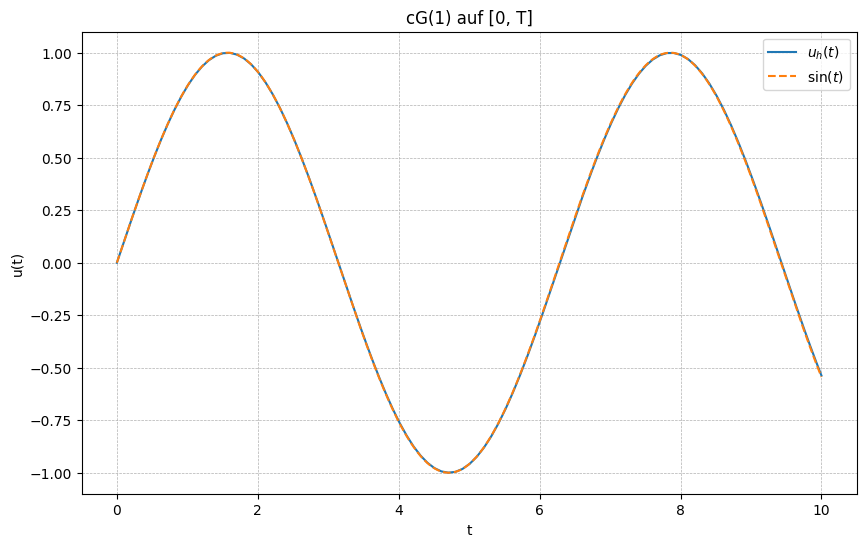

In [209]:
def make_interval_residual(f, n: int, u_initial: np.array, dt: float, quad_m: int = 64):
    """
    Vector residual for one time interval using affine transformation to reference element [-1,1].

    Parameters:
        f (callable): RHS function, returns np.array of shape (d,).
        n (int): Number of dofs per interval (Legendre basis size).
        u_initial (np.array): Initial value u(t_n) used as continuity constraint at s = -1.
        dt (float): Time step size.
        quad_m (int): Gauss-Legendre quadrature degree.

    Returns:
        callable: residual function R(c_flat) for solving coefficients c.
    """
    alpha = 2.0 / dt
    d = int(u_initial.size)

    def residual(c_flat: np.array) -> np.array:
        c = c_flat.reshape(n, d)
        r = np.zeros((n, d))
        for i in range(n - 1):
            def integrand(s: float) -> np.array:
                u_val = np.zeros(d)
                du_val = np.zeros(d)
                for j in range(n):
                    Pj = legendre_polynomial(j, s)
                    dPj = legendre_derivative(j, s)
                    u_val += c[j, :] * Pj
                    du_val += c[j, :] * dPj
                return (alpha * du_val - f(s, u_val)) * legendre_polynomial(i, s)
            r[i, :] = legendre_quadrature_vec(integrand, m=quad_m, d=d)
        u_boundary = np.zeros(d)
        for j in range(n):
            u_boundary += c[j, :] * legendre_polynomial(j, -1.0)
        r[-1, :] = u_boundary - u_initial
        return r.reshape(n * d)
    return residual


def solve_cG_time(f, u0: np.ndarray, T: float, N: int, n_dofs: int, quad_m: int = 64, grid: int = 100) -> tuple:
    """
    Solve u'(t) = f(u(t)) on [0, T] via piecewise cG in time for systems of size d.

    Parameters:
        f (callable): RHS function f(u) returning.
        u0 (np.ndarray): Initial value u(0) with.
        T (float): Final time.
        N (int): Number of time intervals.
        n_dofs (int): Legendre basis size per interval.
        quad_m (int): Quadrature degree per interval.
        grid (int): Number of interpolation points per interval.

    Returns:
        (t_all, U_all): Time grid and solution values.
    """
    t_nodes = np.linspace(0.0, T, N + 1)
    t_all = []
    u_rows = []
    u_left = u0.copy()
    d = u0.size

    for k in range(N):
        t_n, t_np1 = t_nodes[k], t_nodes[k + 1]
        dt = t_np1 - t_n
        residual = make_interval_residual(f, n_dofs, u_left, dt, quad_m=quad_m)
        x0 = np.zeros((n_dofs, d))
        x0[0, :] = u_left
        c_flat = scipy.optimize.fsolve(residual, x0.reshape(n_dofs * d))
        c = c_flat.reshape(n_dofs, d)
        s_grid = np.linspace(-1.0, 1.0, grid)
        V = build_vandermonde(s_grid, n_dofs)
        u_vals = V @ c
        t_grid = affine_trafo(s_grid, t_n, t_np1)
        if k == 0:
            t_all.extend(t_grid.tolist())
            u_rows.extend(u_vals.tolist())
        else:
            t_all.extend(t_grid[1:].tolist())
            u_rows.extend(u_vals[1:].tolist())
        u_right = np.zeros(d)
        for j in range(n_dofs):
            u_right += c[j, :] * legendre_polynomial(j, 1.0)
        u_left = u_right
    return np.array(t_all), np.array(u_rows)


t_all, U_all = solve_cG_time(
    f,
    u0=np.array([0.0, 1.0]),
    T=10.0,
    N=100,
    n_dofs=2,
    quad_m=64,
    grid=100,
)

u1_exact = np.sin(t_all)
u2_exact = np.cos(t_all)
plt.figure(figsize=(10, 6))
plt.plot(t_all, U_all[:, 0], label="$u_h(t)$")
plt.plot(t_all, u1_exact, '--', label="$\\sin(t)$")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.title("cG(1) auf [0, T]")
plt.show()

In [210]:
# RK4-Methode
T = np.linspace(0, 20, 1000)
A = np.array([
    [0, 0, 0, 0],
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 1, 1]
])
b = np.array([1/6, 1/3, 1/3, 1/6])
c = np.array([0, 0.5, 0.5, 1])


def runge_kutta(f: callable, initialwert: np.ndarray, T: np.ndarray, A: np.array, b, c) -> np.ndarray:
    s = A.shape[0]
    n = T.shape[0]
    y = np.zeros((n, len(initialwert)))
    y[0] = initialwert

    for m in range(n-1):
        h = T[m+1]-T[m]
        k = np.zeros((s,len(initialwert)))

        for i in range (0, s):
            k[i] = f(T[m] + c[i] * h, y[m] + h * A[i, :] @ k[:])

        y[m+1] = y[m] + h * b[:] @ k[:]

    return y

[ 0.          0.00029707  0.00059401 ... -0.17955064 -0.17895031
 -0.17833621]
[ 0.00000000e+00  2.73834774e-14  5.47669549e-14 ... -4.58657556e-11
 -4.57427429e-11 -4.56183979e-11]


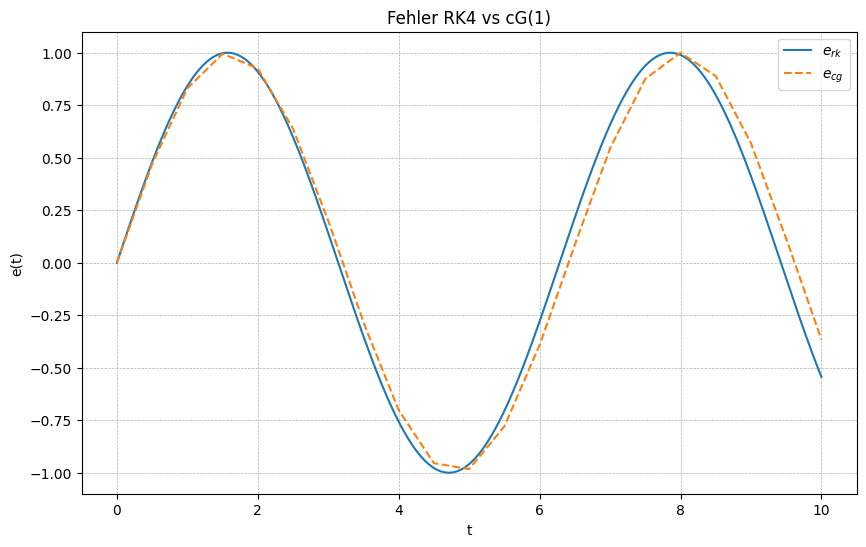

In [211]:
u0 = np.array([0.0, 1.0])

t, u_cg = solve_cG_time(
    f,
    u0,
    T=10.0,
    N=20,
    n_dofs=2,
    quad_m=64,
    grid=100,
)

u_rk = runge_kutta(f, u0, t, A, b, c)

u1_exact = np.sin(t)

error_rk = u1_exact - u_rk[:, 0]
error_cg = u1_exact - u_cg[:, 0]
print(error_cg)
print(error_rk)

plt.figure(figsize=(10, 6))
plt.plot(t, u_rk[:,0], label="$e_{rk}$")
plt.plot(t, u_cg[:,0], '--', label="$e_{cg}$")
#plt.plot(t, u1_exact, label='$u(t)$')
plt.xlabel("t")
plt.ylabel("e(t)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.title("Fehler RK4 vs cG(1)")
plt.show()

In [212]:
def jacobian(f, t: float, u: np.ndarray, h: float = 1e-8) -> np.ndarray:
    n = u.size
    J = np.zeros((n, n))
    for k in range(n):
        e = np.zeros(n)
        e[k] = 1.0
        fp = f(t, u + h * e)
        fm = f(t, u - h * e)
        J[:, k] = (fp - fm) / (2.0 * h)
    return J


def dual_rhs_factory(f, u):
    def g(t: float, z: np.ndarray) -> np.ndarray:
        J = jacobian(f, t, u)
        return - J.T @ z
    return g

J_test = jacobian(f, 1.0, np.array([2.0, 2.0]))
print(J_test)

[[ 0.          0.99999999]
 [-0.99999999  0.        ]]


30.184514558106866
[0. 1.]
0.9735391487823328
[0.  0.5]
0.030662340684357196
[0.   0.25]
0.0009600726802884377
[0.    0.125]
0.030662340684357196
[0.125 0.375]
0.0009600726802884374
[0.125 0.25 ]
0.0306623406843572
[0.25 0.5 ]
0.0009600726802884374
[0.25  0.375]
0.030662340684357192
[0.375 0.625]
0.0009600726802884373
[0.375 0.5  ]
0.030662340684357203
[0.5  0.75]
0.0009600726802884385
[0.5   0.625]
0.030662340684357182
[0.625 0.875]
0.0009600726802884386
[0.625 0.75 ]
0.030662340684357196
[0.75 1.  ]
0.0009600726802884383
[0.75  0.875]
0.030662340684357203
[0.875 1.125]
0.0009600726802884376
[0.875 1.   ]
0.0306623406843572
[1.   1.25]
0.0009600726802884373
[1.    1.125]
0.03066234068435721
[1.125 1.375]
0.0009600726802884377
[1.125 1.25 ]
0.030662340684357206
[1.25 1.5 ]
0.0009600726802884377
[1.25  1.375]
0.030662340684357192
[1.375 1.625]
0.0009600726802884376
[1.375 1.5  ]
0.030662340684357206
[1.5  1.75]
0.0009600726802884377
[1.5   1.625]
0.0306623406843572
[1.625 1.875]
0.00096

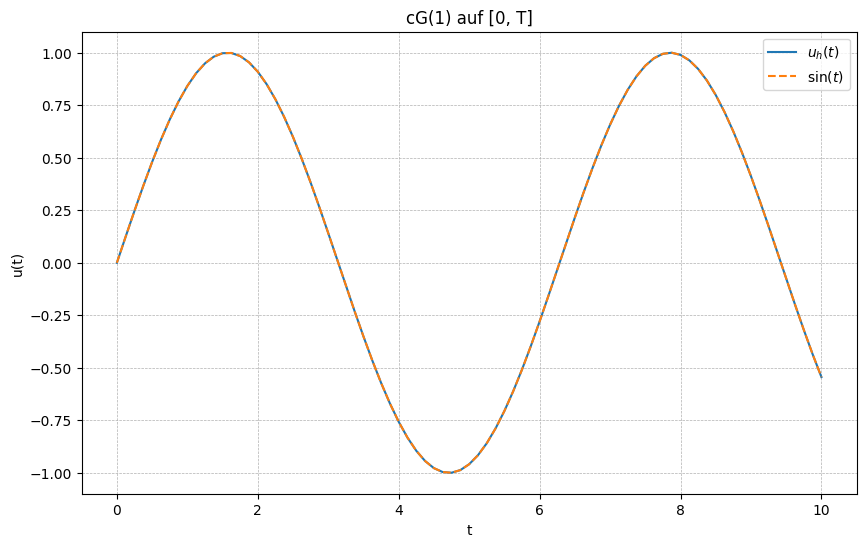

In [ ]:
def solve_cG_step(f, u0: np.ndarray, t_node: np.array, n_dofs: int, quad_m: int = 64, grid: int = 100) -> np.array:
    """
    Solves u'(t) = f(u(t)) for a single time step [t_{n-1}, t_n] via piecewise cG in time for systems of size d.

    Parameters:
        f (callable): RHS function f(u) returning.
        u0 (np.ndarray): Initial value u(t_{n-1}).
        t_node (np.array): Time interval.
        n_dofs (int): Legendre basis size per interval.
        quad_m (int): Quadrature degree per interval.
        grid (int): Number of interpolation points per interval.

    Returns:
        np.array: Solution at the interval endpoints [u_{n-1}, u_n].
    """
    d = u0.size
    t_n, t_np1 = t_node[0], t_node[1]
    h = t_np1 - t_n

    residual = make_interval_residual(f, n_dofs, u0, h, quad_m=quad_m)
    x0 = np.zeros((n_dofs, d))
    x0[0, :] = u0
    c_flat = scipy.optimize.fsolve(residual, x0.reshape(n_dofs * d))
    c = c_flat.reshape(n_dofs, d)

    u_left = u0.copy()
    u_right = np.zeros(d)
    for j in range(n_dofs):
        u_right += c[j, :] * legendre_polynomial(j, 1.0)

    return np.vstack([u_left, u_right])


def adaptive_cg_method(f, u0: np.ndarray, h: float, t0: float, T: float, n_dofs: int, quad_m: int = 64, grid: int = 100, TOL: float = 1e-8):
    N = int((T-t0)/h)
    t, sol = solve_cG_time(f, u0=u0, T=T, N=N, n_dofs=n_dofs, quad_m=quad_m, grid=grid)
    t_half, sol_half = solve_cG_time(f, u0=u0, T=T, N=2*N, n_dofs=n_dofs, quad_m=quad_m, grid=grid)

    while np.linalg.norm(sol[-1,:] - sol_half[-1,:]) > TOL:
        print(np.linalg.norm(sol[-1,:] - sol_half[-1,:]))
        N = 2*N
        t, sol = solve_cG_time(f, u0=u0, T=T, N=N, n_dofs=n_dofs, quad_m=quad_m, grid=grid)
        t_half, sol_half = solve_cG_time(f, u0=u0, T=T, N=2*N, n_dofs=n_dofs, quad_m=quad_m, grid=grid)

    h = float((T-t0)/N)

    t_all = []
    u_all = []

    while t0 < T:
        tnode = np.array([t0, min(t0 + h, T)])
        sol_interval = solve_cG_step(f, u0=u0, t_node=tnode, n_dofs=n_dofs, quad_m=quad_m, grid=grid)

        resid = (sol_interval[1,:] - sol_interval[0,:]) / (tnode[1] - tnode[0])
        dual_problem = dual_rhs_factory(f, sol[-1,:])
        z0 = (sol[-1,:] - sol_half[-1,:]) / np.linalg.norm(sol[-1,:] - sol_half[-1,:])
        z = runge_kutta(dual_problem, z0, t, A, b, c)
        indicator = np.linalg.norm(resid) * np.linalg.norm(z) * (tnode[1] - tnode[0])**(n_dofs+1)
        print(indicator)
        print(tnode)

        if indicator > TOL:
            h = h / 2
            continue
        else:
            t_all.extend(tnode.tolist())
            u_all.extend(sol_interval.tolist())
            u0 = sol_interval[1, :]
            t0 = tnode[1]
            h = min(2 * h, T - t0) if t0 < T else h

    return np.array(t_all), np.array(u_all)


t_all, U_all = adaptive_cg_method(
    f,
    u0=np.array([0.0, 1.0]),
    h=1.0,
    t0=0.0,
    T=10.0,
    n_dofs=4,
    quad_m=64,
    grid=100,
    TOL=1e-8,
)

u1_exact = np.sin(t_all)
u2_exact = np.cos(t_all)
plt.figure(figsize=(10, 6))
plt.plot(t_all, U_all[:, 0], label="$u_h(t)$")
plt.plot(t_all, u1_exact, '--', label="$\\sin(t)$")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.title("Adaptives cG(r) auf [0, T]")
plt.show()